### Importing utils 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
MOVIELENS_PATH = '/Users/patrykkowalczyk/Desktop/ml-latest-small/'
RATINGS_FILE = 'ratings.csv'
LINKS_FILE = 'links.csv'
MOVIES_FILE = 'movies.csv'
TAGS_FILE = 'tags.csv'

In [3]:
RATINGS_HEADERS = 'userId,movieId,rating,timestamp'
LINKS_HEADERS = 'movieId,imdbId,tmdbId'
MOVIES_HEADERS = 'movieId,title,genres'
TAGS_HEADERS = 'userId,movieId,tag,timestamp'

In [4]:
def get_data(movielens_path, filename, headers):
    path = movielens_path + filename
    print 'Getting data from %s' % path 
    return pd.read_csv(path, sep=',', names=headers.split(","))[1:]

def get_ratings():
    return get_data(MOVIELENS_PATH, RATINGS_FILE, RATINGS_HEADERS)

def get_links():
    return get_data(MOVIELENS_PATH, LINKS_FILE, LINKS_HEADERS)

def get_movies():
    return get_data(MOVIELENS_PATH, MOVIES_FILE, MOVIES_HEADERS)

def get_tags():
    return get_data(MOVIELENS_PATH, TAGS_FILE, TAGS_HEADERS)

### Get ratings data from file

In [5]:
ratings = get_ratings()

Getting data from /Users/patrykkowalczyk/Desktop/ml-latest-small/ratings.csv


In [6]:
ratings.head()

userId movieId rating   timestamp
1      1      31    2.5  1260759144
2      1    1029    3.0  1260759179
3      1    1061    3.0  1260759182
4      1    1129    2.0  1260759185
5      1    1172    4.0  1260759205

In [7]:
def get_users_and_movies(ratings_dataset):
    n_users, n_movies = len(ratings_dataset.userId.unique()), len(ratings_dataset.movieId.unique())
    print 'Number of users: %d\nNumber of rated movies: %d' % (n_users, n_movies)
    return n_users, n_movies

In [8]:
n_users, n_movies = get_users_and_movies(ratings)

Number of users: 671
Number of rated movies: 9066


### Transform user IDs and movie IDs to have values from range (0, N-1)

In [11]:
ratings.userId = ratings.userId.astype('category').cat.codes.values
ratings.movieId = ratings.movieId.astype('category').cat.codes.values

In [12]:
ratings.head()

userId  movieId rating   timestamp
1       0     3079    2.5  1260759144
2       0      106    3.0  1260759179
3       0      242    3.0  1260759182
4       0      488    2.0  1260759185
5       0      608    4.0  1260759205

**Train test split**
We'll now split our dataset of 100k ratings into train (containing 80k ratings) and test (containing 20k ratings). Given the train set, we'd like to accurately estimate the ratings in the test set.

In [13]:
train, test = train_test_split(ratings, test_size=0.2)

In [14]:
train.head()

userId  movieId rating   timestamp
48341     283        0    5.0   846062607
88585     541     7370    4.0  1111968788
8596      511     5890    2.0  1470350845
56911     344     2962    5.0   828212412
60270     373     1289    3.0   891508001

In [15]:
test.head()

userId  movieId rating   timestamp
37562     190     4767    2.5  1469306353
98376     620     1518    4.0   941488782
63144     397     1422    4.5  1471384496
23376      73     2070    3.5  1111482199
57435     352     5028    3.0   841447200

In [16]:
import keras
from IPython.display import SVG
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
from keras.constraints import non_neg

n_users, n_movies = get_users_and_movies(ratings)

Using TensorFlow backend.


Number of users: 671
Number of rated movies: 9066


In [17]:
def fit_model(model_to_fit, train_data, epochs=10, verbose=0):
    return model_to_fit.fit([train_data.userId, train_data.movieId], train_data.rating, epochs=epochs, verbose=verbose)

def round_to_0_5(values):
    return np.round(values * 2) / 2

def predict(model, test_data, should_round=True):
    predicted = model.predict([test_data.userId, test_data.movieId])
    if should_round:
        predicted = round_to_0_5(predicted)
    return test_data.rating, predicted
    
def draw_model_fit(fitted_model):
    pd.Series(fitted_model.history['loss']).plot(logy=True)
    plt.xlabel("Epoch")
    plt.ylabel("Train Error")

def get_metrics(y_true, y_predicted):
    mean_abs_err = mae(y_true, y_predicted)
    mean_sq_err = mse(y_true, y_predicted)
    print 'Mean absolute error: %.4f\nMean squared error: %.4f' % (mean_abs_err, mean_sq_err)
    return mean_abs_err, mean_sq_err

def draw_nn_model(model):
    return SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

def summarise_nn_model(model):
    return model.summary()

### Using neural network

In [18]:
LATENT_FACTORS_USERS = 5
LATENT_FACTORS_MOVIES = 8
LEARNING_RATE = .005

In [19]:
class DenseLayers(object):
    def __init__(self, input_layer):
        self.layers = [input_layer]
        
    def add_dense_layer(self, layer_size, name='FullyConnected', dropout=.2, activation=None):
        layer_index = len(self.layers)
        
        layer_name = name
        if name == 'FullyConnected':
            layer_name += '-%d' % layer_index
        dropout_name = '%s_Dropout' % layer_name

        preceding_layer = self.layers[-1]
        dense_layer = keras.layers.Dense(layer_size, name=layer_name, activation=activation)(preceding_layer)
        
        if dropout is not None:
            self.layers.append(keras.layers.Dropout(dropout, name=dropout_name)(dense_layer))
        else:
            self.layers.append(dense_layer)
        return self

    def add_relu_dense_layer(self, layer_size, name='FullyConnected', dropout=.2):
        return self.add_dense_layer(layer_size, name, dropout, 'relu')

    def build_model(self, users, movies, learning_rate, loss_function='mean_absolute_error'):
        adam = Adam(lr=learning_rate)
        output_layer = self.layers[-1]
        model = keras.Model([users, movies], output_layer)
        model.compile(optimizer=adam, loss=loss_function)
        return model

In [20]:
# Movie input layers
movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(n_movies + 1, LATENT_FACTORS_MOVIES, name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)
movie_vec = keras.layers.Dropout(0.2, name='FlattenMovies_Dropout')(movie_vec)

# User input layers
user_input = keras.layers.Input(shape=[1],name='User')
user_embedding = keras.layers.Embedding(n_users + 1, LATENT_FACTORS_USERS,name='User-Embedding')(user_input)
user_vec = keras.layers.Flatten(name='FlattenUsers')(user_embedding)
user_vec = keras.layers.Dropout(0.2, name='FlattenUsers_Dropout')(user_vec)

# Concatenation: movies + users
concat = keras.layers.merge([movie_vec, user_vec], mode='concat',name='Concat')
concat_dropout = keras.layers.Dropout(0.2, name='Concat_Dropout')(concat)

model = DenseLayers(concat_dropout) \
    .add_dense_layer(200) \
    .add_dense_layer(100) \
    .add_relu_dense_layer(20) \
    .add_relu_dense_layer(1, 'Activation', None) \
    .build_model(user_input, movie_input, LEARNING_RATE)

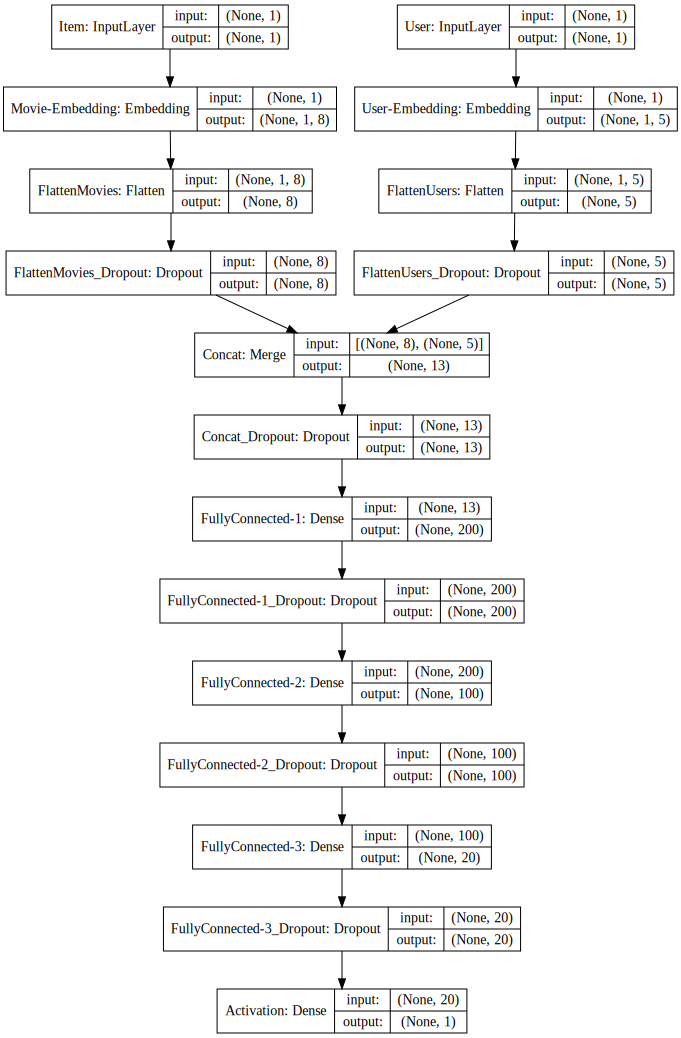

In [21]:
draw_nn_model(model)

In [22]:
# summarise_nn_model(model)

In [23]:
fitted_model = fit_model(model, train, 10, 1)

Epoch 1/10
80003/80003 [==============================] - 7s 91us/step - loss: 0.8403
Epoch 2/10
80003/80003 [==============================] - 6s 76us/step - loss: 0.7233
Epoch 3/10
80003/80003 [==============================] - 6s 77us/step - loss: 0.7022
Epoch 4/10
80003/80003 [==============================] - 6s 76us/step - loss: 0.6911
Epoch 5/10
80003/80003 [==============================] - 6s 79us/step - loss: 0.6871
Epoch 6/10
80003/80003 [==============================] - 7s 82us/step - loss: 0.6820
Epoch 7/10
80003/80003 [==============================] - 7s 84us/step - loss: 0.6786
Epoch 8/10
80003/80003 [==============================] - 7s 88us/step - loss: 0.6764
Epoch 9/10
80003/80003 [==============================] - 6s 80us/step - loss: 0.6711
Epoch 10/10
80003/80003 [==============================] - 6s 80us/step - loss: 0.6709


In [24]:
y_true, y_predicted = predict(model, test)

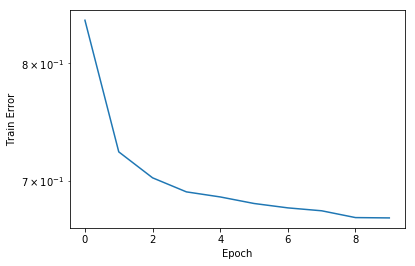

In [25]:
draw_model_fit(fitted_model)

In [26]:
mean_abs_err, mean_sq_err = get_metrics(y_true, y_predicted)

Mean absolute error: 0.6870
Mean squared error: 0.8773


In [267]:
links = get_links()

Getting data from /Users/patrykkowalczyk/Desktop/ml-latest-small/links.csv


In [305]:
merged = pd.merge(ratings, links, on='movieId', how='left')
merged = merged.loc[merged['imdbId'].notnull()].drop(['tmdbId', 'timestamp'], axis=1)

merged['movieId'] = merged['imdbId']
merged.userId = merged.userId.astype('category').cat.codes.values
merged.movieId = merged.movieId.astype('category').cat.codes.values

m2 = pd.merge(ratings, links, on='movieId', how='left')
m2 = m2.loc[m2['imdbId'].notnull()]
m2.shape

(67241, 6)

In [294]:
n_users, n_movies = len(merged.userId.unique()), len(merged.imdbId.unique())
print 'Number of users: %d\nNumber of rated movies: %d' % (n_users, n_movies)

Number of users: 671
Number of rated movies: 5657


In [298]:
train, test = train_test_split(merged, test_size=0.2)

In [300]:
# Movie input layers
imdb_input = keras.layers.Input(shape=[1],name='Movie')
imdb_embedding = keras.layers.Embedding(n_movies + 1, LATENT_FACTORS_MOVIES, name='Movie-Embedding')(imdb_input)
imdb_vec = keras.layers.Flatten(name='FlattenMovies')(imdb_embedding)
imdb_vec = keras.layers.Dropout(0.2, name='FlattenMovies_Dropout')(imdb_vec)

# User input layers
user_input = keras.layers.Input(shape=[1],name='User')
user_embedding = keras.layers.Embedding(n_users + 1, LATENT_FACTORS_USERS,name='User-Embedding')(user_input)
user_vec = keras.layers.Flatten(name='FlattenUsers')(user_embedding)
user_vec = keras.layers.Dropout(0.2, name='FlattenUsers_Dropout')(user_vec)

# Concatenation: movies + users
concat = keras.layers.merge([movie_vec, user_vec], mode='concat',name='Concat')
concat_dropout = keras.layers.Dropout(0.2, name='Concat_Dropout')(concat)

model = DenseLayers(concat_dropout) \
    .add_dense_layer(200) \
    .add_dense_layer(100) \
    .add_dense_layer(50) \
    .add_relu_dense_layer(20) \
    .add_relu_dense_layer(1, 'Activation', None) \
    .build_model(user_input, movie_input, LEARNING_RATE)

In [282]:
# draw_nn_model(model)
# summarise_nn_model(model)

In [283]:
fitted_model = fit_model_imdb(model, train, 20, 1)

Epoch 1/20
15424/53792 [=======>......................] - ETA: 7s - loss: 1.1473

KeyboardInterrupt: 

In [235]:
y_true, y_predicted = predict_imdb(model, test)

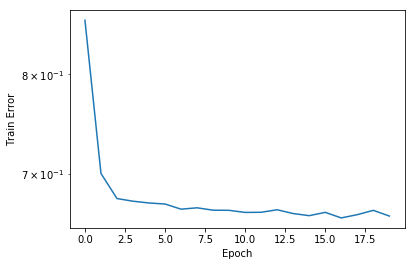

In [236]:
draw_model_fit(fitted_model)

In [237]:
mean_abs_err, mean_sq_err = get_metrics(y_true, y_predicted)

Mean absolute error: 0.6703
Mean squared error: 0.8552


In [258]:
# merged.groupby('imdbId')['imdbId'].filter(lambda x: len(x) >= 100)


In [259]:
merged[:10]

userId movieId rating  imdbId
0        0    3079    2.5    4631
2        0     242    3.0    3126
3        0     488    2.0    2968
4        0     608    4.0    3631
5        0     767    2.0    3396
7        0     830    2.0    3637
8        0     931    3.5     246
9        0     940    2.0     110
10       0    1004    2.5    3653
11       0    1063    1.0    3686

In [261]:
get_links()[:10]

Getting data from /Users/patrykkowalczyk/Desktop/ml-latest-small/links.csv


movieId   imdbId tmdbId
1        1  0114709    862
2        2  0113497   8844
3        3  0113228  15602
4        4  0114885  31357
5        5  0113041  11862
6        6  0113277    949
7        7  0114319  11860
8        8  0112302  45325
9        9  0114576   9091
10      10  0113189    710